# AIT Project - Mid Semester Evaluation

**Alan Gaugler**  
**U885853**  
**October 8, 2023**  

This version uses a Naive-Bayes model with Tf-Idf and word2vec. Results are poor on the 42 classes. 

The best Naive-Bayes model achieved an accuracy of 57.8% using bag of words.  
The Logistic Regression model achieved an accuracy of 60.5% using a Tf-idf vectorizer.  

Text preparation is place into one function.

# <span style="color: darkblue;">Introduction</span>

This project is concerned with article classification. A news category dataset with over 200,000 article headlines and descriptions will be used in this project. The aim is to read and interpret the headlines and descriptions and categorize them into one of 42 topic categories.

**Import the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import re
import string
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
#warnings.filterwarnings('ignore')

### Exploratory Data Analysis

In [2]:
# Load the JSON file
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [3]:
# Display the header
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


The dataset consists of 6 columns:

**link:** The URL of the news article.<br>
**headline:** The headline of the article.<br>
**category:** The category of type or article. This is the target variable.<br>
**short_description:** A short description of the article. This will be key in identyfying the article category.<br>
**authours:** The names of the article's authours.<br>
**date:** The date of the article's publication.<br>

In [4]:
df.shape

(209527, 6)

This is a large dataset with 209527 articles.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


All columns are objects except for the date which is datetime.

In [6]:
df.describe()

C:\Users\alang\AppData\Local\Temp\ipykernel_46288\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,3890
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,2014-03-25 00:00:00
freq,2,90,35602,19712,37418,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


In [7]:
# Find the number of missing values in each column
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

There are no missing values in the dataset.

In [8]:
# Are there any duplicate headlines?
df['headline'].value_counts()

Sunday Roundup                                                                  90
The 20 Funniest Tweets From Women This Week                                     80
Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS)                          59
Weekly Roundup of eBay Vintage Home Finds (PHOTOS)                              54
Watch The Top 9 YouTube Videos Of The Week                                      46
                                                                                ..
Here Are The Manufacturers Bringing The Most Jobs Back to America                1
2016 Campaigns Meet With White House To Prep For Obama's Last Days In Office     1
If Toddlers Could Calmly Articulate Their Feelings                               1
Snapchat's Bob Marley Filter Called Out For Being 'Digital Blackface'            1
Dwight Howard Rips Teammates After Magic Loss To Hornets                         1
Name: headline, Length: 207996, dtype: int64

Yes. There are many headlines that are duplicates. They all appear to be weekly articles.

In [9]:
# Are there any duplicate short descriptions?
df['short_description'].value_counts()

                                                                                                                                 19712
Welcome to the HuffPost Rise Morning Newsbrief, a short wrap-up of the news to help you start your day.                            192
The stress and strain of constantly being connected can sometimes take your life -- and your well-being -- off course. GPS         125
Want more? Be sure to check out HuffPost Style on Twitter, Facebook, Tumblr, Pinterest and Instagram at @HuffPostStyle. -- Do       91
Do you have a home story idea or tip? Email us at homesubmissions@huffingtonpost.com. (PR pitches sent to this address will         75
                                                                                                                                 ...  
The "Selma" director is teaming up with Oprah for her first ever TV series.                                                          1
It's one of the thorniest moral dilemmas in tech right 

**There are duplicate short descriptions.  
The headline and the short description columns will be merged togther for the analysis**<br>
This will reduce the number of duplicates.

In [10]:
# Display all the categories
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [11]:
df['category'].nunique()

42

There are 42 unique values. These will be the categories.

In [12]:
# Display the number of articles per category
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

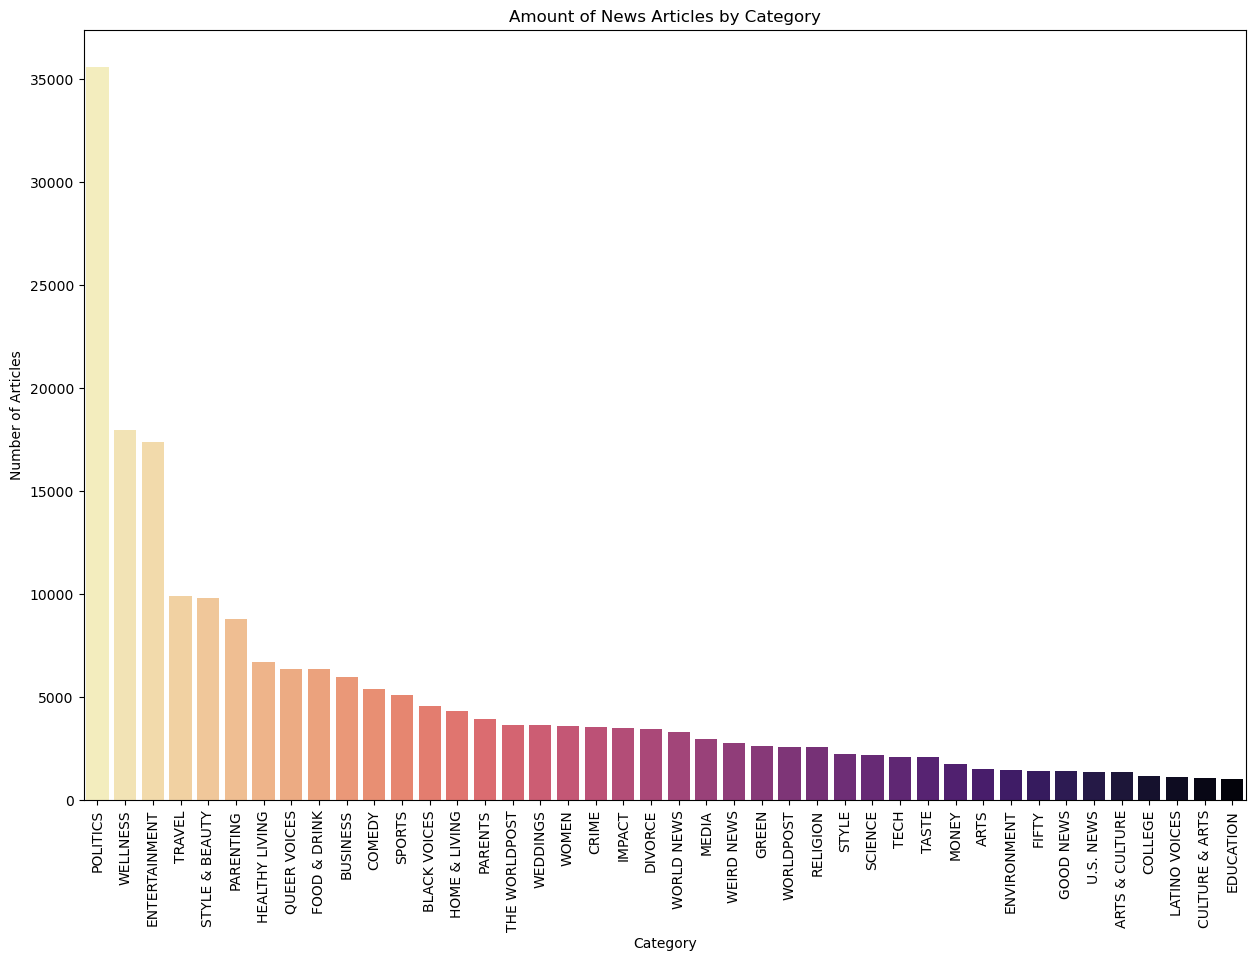

In [13]:
# Plot the distribution of news articles by news category.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['category'], order=df['category'].value_counts().index, palette="magma_r")
plt.title('Amount of News Articles by Category')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()


Politics is by far the most common category in this dataset, followed by wellness and entertainment. This dataset is clearly very imbalanced. This will produce challenges in predicting the minority categories.

In [14]:
# Add extra columns to count the number of words in the headline and the short description
df['word_count_headline'] = df['headline'].apply(lambda text: len(str(text).split()))
df['word_count_description'] = df['short_description'].apply(lambda text: len(str(text).split()))

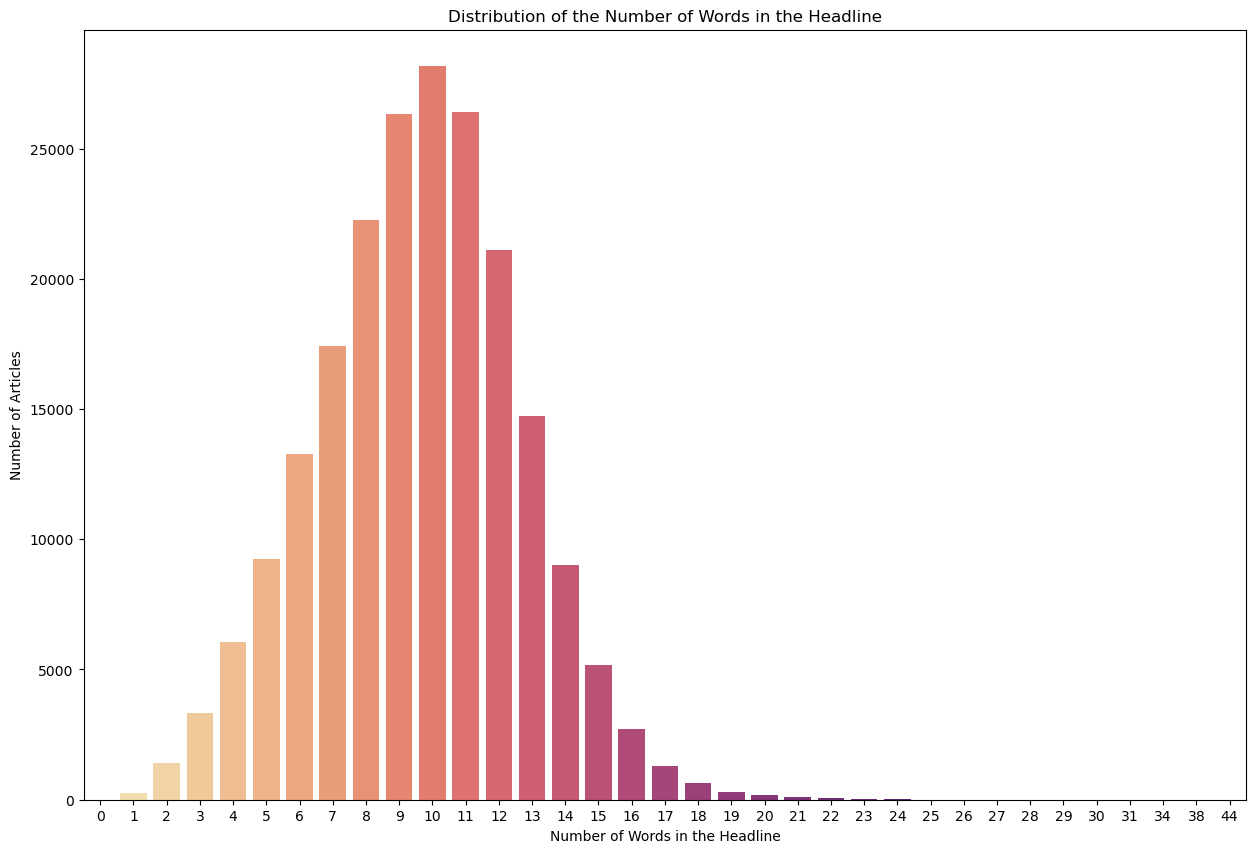

In [15]:
# Plot the Distribution of the Number of Words in the Headline.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['word_count_headline'], 
                   order=df['word_count_headline'].value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Headline')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Headline')
plt.show()

The number of words per headline has a fairly normalized distribution, centered on 10 words.

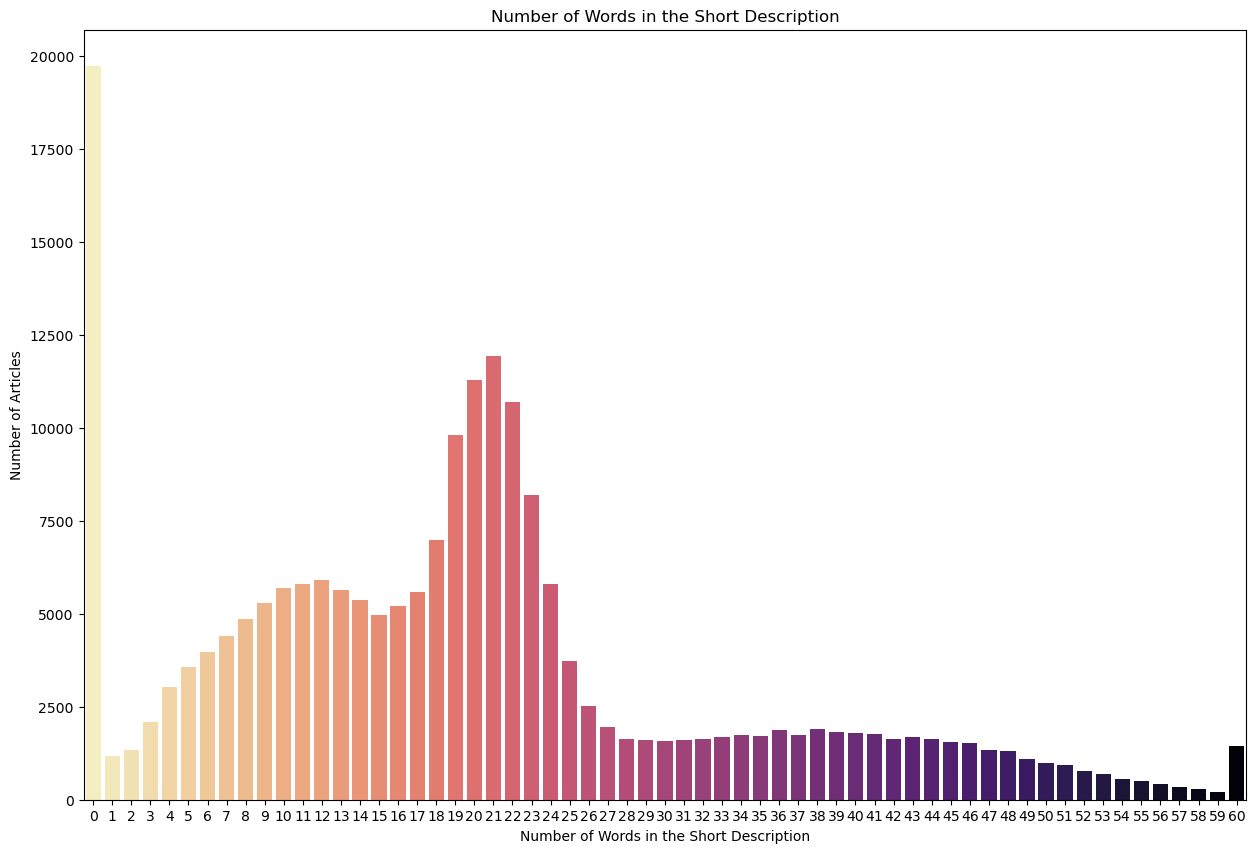

In [16]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_word_count = df['word_count_description'].apply(lambda x: 60 if x >= 60 else x)

plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_word_count, 
                   order=capped_word_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Number of Words in the Short Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Short Description')
plt.show()

Looking at the plot above, there are 19712 articles in this dataset that do not have a description, but rather just a headline. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.<br>
The distribution of the number of words in the short description interestingly has 3 peaks. The first peak is at 12 words, the largest peak is at 21 words and the smallest is at 38 words. This distribution is definitely not normal. It will be investigated to see if there is any correlation between the category and the word length of the short description.

There are 19712 articles that have no description and 6 that have no headline. To get a more complete view of the article, the headline and the short description will be merged together into a new feature called 'combined_information'.

In [17]:
# Create a new feature that concatenates 'headline' and 'short_description'.
df['combined_info'] = df['headline'].str.strip() + ' ' + df['short_description'].str.strip()

# Create an extra column to count the number of words in the combined_info feature.
df['word_count_combined'] = df['combined_info'].apply(lambda text: len(str(text).split()))

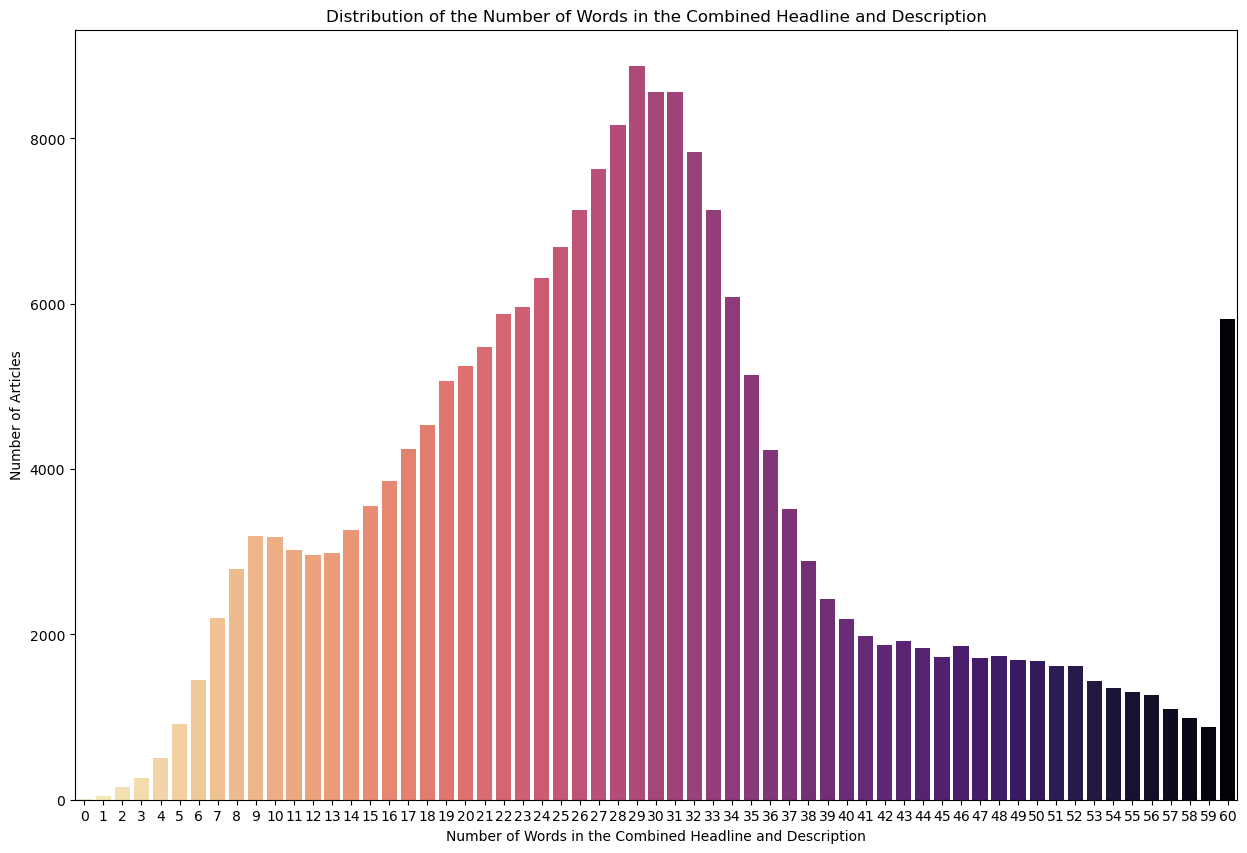

In [18]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_combined_count = df['word_count_combined'].apply(lambda x: 60 if x >= 60 else x)

# Plot the Distribution of the Number of Words in the Combined Information.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_combined_count, 
                   order=capped_combined_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Combined Headline and Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Combined Headline and Description')
plt.show()

The peak of the combined word distribution is centred on 29 words. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.<br>

In [19]:
# Are there any duplicates in the combined info column?
df['combined_info'].value_counts()

Watch The Top 9 YouTube Videos Of The Week If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the                                         46
The Funniest Tweets From Women This Week                                                                                                                                                                     33
The 20 Funniest Tweets From Women This Week The ladies of Twitter never fail to brighten our days with their brilliant ― but succinct ― wisdom. Each week, HuffPost Women                                    30
Best Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each week, we round up the most hilarious        26
Funniest Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each wee

There are still duplicates in the 'combined_info' column, but this number has been reduced to just 46. 46 out of 209,527 is extremely low and will not bias the results significantly. These are articles that were actually published, so they will not be removed from this project.

In [20]:
# Create new columns for the year and month of publication.
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

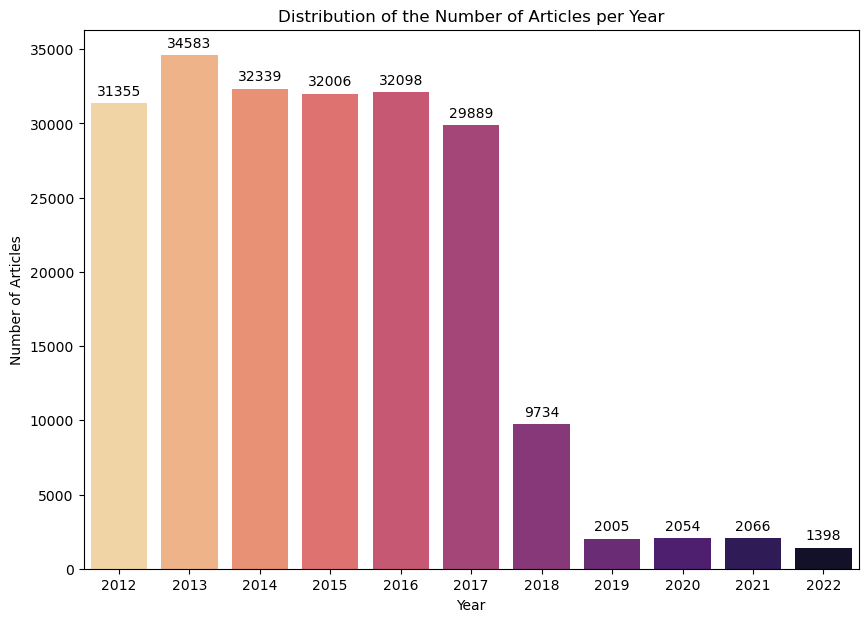

In [21]:
# Plot the Distribution of the Number of Articles per Year.
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=df['year'], 
                   order=df['year'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Year')
plt.ylabel('Number of Articles')
plt.xlabel('Year')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The original dataset was made in June 2018, when a roughly even amount of articles were collected from 2012 to May 2018. Since then, there have been updates to the dataset but not as many new articles were collected.

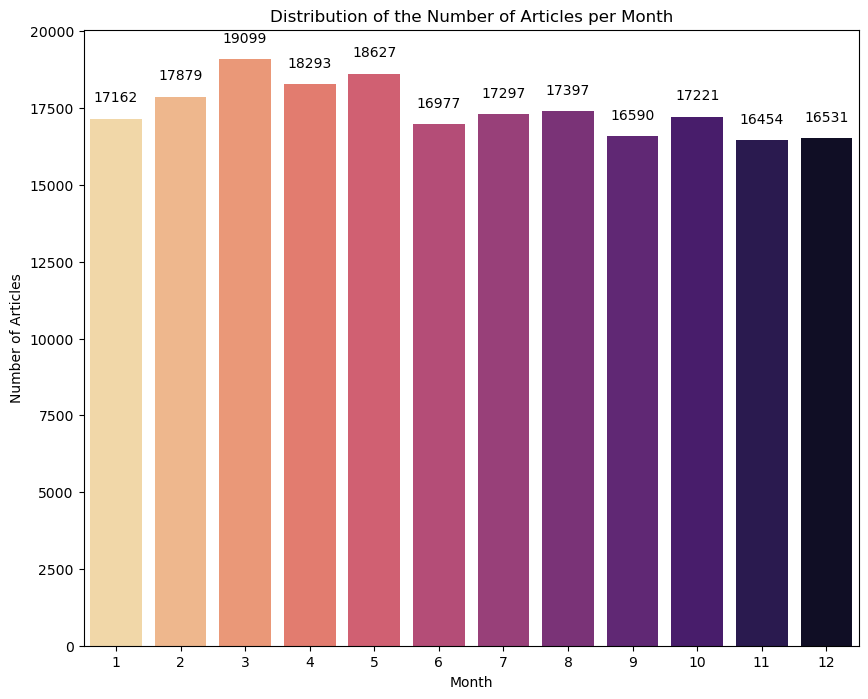

In [22]:
# Plot the Distribution of the Number of Articles per Month.
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df['month'], 
                   order=df['month'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Month')
plt.ylabel('Number of Articles')
plt.xlabel('Month')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The number of articles distributed per month is relatively even. The busiest month is March with 19099 and the quietest are November and December at around 16500. These months are during the holiday period in the US and more journalists may be taking time off.

In [23]:
df.describe()

,word_count_headline,word_count_description,word_count_combined,year,month
count,209527.000000,209527.000000,209527.000000,209527.000000,209527.000000
mean,9.600744,19.669026,29.269770,2014.837634,6.393100
std,3.068507,14.152783,13.803927,2.087349,3.429701
min,0.000000,0.000000,0.000000,2012.000000,1.000000
25%,8.000000,10.000000,20.000000,2013.000000,3.000000
50%,10.000000,19.000000,28.000000,2015.000000,6.000000
75%,12.000000,24.000000,35.000000,2016.000000,9.000000
max,44.000000,243.000000,245.000000,2022.000000,12.000000


In [24]:
# Observe if any 'combined_info' column is empty or contains just one word.
df[df['word_count_combined'] <= 1].head(10)

,link,headline,category,short_description,authors,date,word_count_headline,word_count_description,combined_info,word_count_combined,year,month
63714,https://www.huffingtonpost.com/entry/manscrapi...,"""ManScraping""",COMEDY,,"Tom Kramer, ContributorWriter of the Wry",2016-06-26,1,0,"""ManScraping""",1,2016,6
66196,https://www.huffingtonpost.com/entry/tire-d_b_...,Tire-d,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2016-05-29,1,0,Tire-d,1,2016,5
66203,https://www.huffingtonpost.com/entry/wafflewic...,Wafflewich,TASTE,,"Dough Mamma, ContributorPrivate chef, culinary...",2016-05-29,1,0,Wafflewich,1,2016,5
72366,https://www.huffingtonpost.com/entry/hangman_b...,Hangman,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2016-03-19,1,0,Hangman,1,2016,3
78481,https://www.huffingtonpost.com/entry/hugs_b_89...,Hugs,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2016-01-10,1,0,Hugs,1,2016,1
81477,https://www.huffingtonpost.com/entry/memories_...,Memories,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2015-12-06,1,0,Memories,1,2015,12
81496,https://www.huffingtonpost.com/entry/what-to-d...,IGNORE.,POLITICS,,"Gabriela Rivera-Morales, ContributorBlog Edito...",2015-12-06,1,0,IGNORE.,1,2015,12
82119,https://www.huffingtonpost.com/entry/podcast_b...,Podcast,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2015-11-29,1,0,Podcast,1,2015,11
86508,https://www.huffingtonpost.com/entry/the-ideal...,Once.,COMEDY,,"Marcia Liss, Contributor(Almost) Famous Cartoo...",2015-10-11,1,0,Once.,1,2015,10
90944,https://www.huffingtonpost.com/entry/lincoln-2...,,POLITICS,,"Robert Moran, ContributorRobert Moran leads Br...",2015-08-22,0,0,,0,2015,8


In [25]:
len(df[df['word_count_combined'] <= 1])

53

Five rows were found to not have any textual information at all in the 'combined info' column. If this column is empty, no information can be conveyed into what category it belongs to. One word is also too little information to accurately classify the topic. These rows will be removed.

In [26]:
df = df[df['word_count_combined'] > 1].copy()

In [27]:
df.shape

(209474, 12)

## Feature Engineering / Data Preparation

### <span style="color: darkblue;">Text Cleaning and Preprocessing</span>

To prepare the data for natural language processing (NLP), several steps will need to be taken:<br>

1. Text Cleaning - The preprocessing step will convert the text to lowercase, strip and remove punctuations, effectively cleaning the text for further processing. 
2. Expand contractions - Contracted words are converted into two words which make more sense. Also, the apostrophes will be removed. An example of this is: "I'd" --> "I would". Many of these words will be removed by the stop word removal step.  
3. Tokenization - Partition the text into individual words and symbols. These are called tokens.
4. Stop word removal - This will remove common words that convey no meaning about the article such as "he", "she" or "on".
5. Stemming - This reduces words to their root form i.e., "shows", "showing" and "showed" will be reduced to "show".
6. Lemmatization - This also reduces words to their root form i.e., "better" and "best" will be reduced to "good". This is similar to stemming but the root words are more often real words used in English rather than just their stems.  
7. Bigrams and trigrams - Many words often connected in sequence may have a different meaning and should be joined together such as "New" followed by "York" really conveys the meaning of a city called "New York" and they should be considered one word.
8. Removal of unique words - Unique words or words that occur only one time in the entire dataset will be removed. As these words are unique, they will not be encountered in the test set if they are in the training set and so will not convey any information in identifying the topic category. This will also reduce the “noise” in the dataset and speed up processing.
  

The Natural Language Toolkit (NLTK) and Gensim libraries will be used for this project.

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim
from gensim.models import Word2Vec

In [30]:
# Install the necessary NLTK datasets if they are not in the environment yet.
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [31]:
# Define the English language stopwords.
stop_words = set(stopwords.words('english'))

# Load the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [32]:
# Display the English stopwords in the NLTK library
print(stop_words)

{"aren't", 's', "you've", 'isn', 'doesn', 'itself', 'if', 'the', 'doing', 'under', 'his', "couldn't", 'not', 'wouldn', 'in', 'how', 'mustn', 'a', 'whom', 'again', 'weren', 'down', 'hasn', 'were', 'won', 'mightn', 'she', 'her', 'few', 'or', 'did', "haven't", 'be', 'you', 'm', 'themselves', 'on', 'too', 'is', 'am', 'our', "weren't", 'nor', "won't", 'are', 'o', 'only', 'these', 'don', "should've", 'during', 'from', 'have', 'shan', 'they', 'there', 'but', 'and', 'once', 'yourself', 'wasn', "mightn't", 'very', 'has', 'hadn', "you're", 'this', "shouldn't", 'further', "wasn't", 'up', "isn't", 'was', 'where', 'now', 'below', 'as', 'does', 'my', 'i', 'me', 'what', 'between', 'having', 'had', 'your', 'such', 'ain', 'it', 'who', 'after', 'been', 'just', "shan't", 'y', "that'll", "needn't", 'will', 'ours', 'over', 'no', 're', 'with', 'because', 'an', 'both', 'each', "she's", "you'd", 'any', 'some', "hadn't", 'll', 'why', 'against', 'than', 'ma', 'yourselves', 'd', 'here', 'him', 'most', 'off', 'he

In [33]:
len(stop_words)

179

NLTK's English stopwords library contains 179 words.

In [34]:
df.dtypes

link                              object
headline                          object
category                          object
short_description                 object
authors                           object
date                      datetime64[ns]
word_count_headline                int64
word_count_description             int64
combined_info                     object
word_count_combined                int64
year                               int64
month                              int64
dtype: object

In [35]:
# Make a contractions map:
# A contraction map will convert contracted words into two words
# which make more sense. Also, the apostrophes will be removed.
# Credit: This contraction map was obtained from the following source:
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


In [36]:
# Credit: This function to expand contractions was obtained from the following source:
# https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [37]:
# Credit: The processing text function shown below is based on code found at the following source:
# Reference: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
# The preprocessing step will convert the text to lowercase, strip and remove punctuations
# effectively cleaning the text for further processing.

def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Call the expand contractions function
    # It was found that this led to a minore decreae in model performance so it has been commented out.
    #text = expand_contractions(text)
    # Remove any leading or trailing whitespace.
    text = text.strip()
    # Remove any HTML tags from the text
    text = re.compile('<.*?>').sub('', text)
    # Replace any punctuation with a space
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    # Remove any square-bracketed numbers (like [10], [23], etc.)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    # Remove any non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [38]:
# Create a wordcloud for the desired column
def plot_word_cloud(lemmatized_words, col_name):
    # Combine all the words into one list instead of a list of lists
    word_list = [word for sublist in lemmatized_words for word in sublist]

    # Combine all the words into one large text
    text = ' '.join(word_list)

    # Create the word cloud object
    wc = WordCloud(width=800, height=800, colormap='Spectral', background_color='black', 
                   stopwords=set('english'), max_words=200, contour_color='black')

    # Generate the word cloud
    wc.generate(text)

    # Display the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {col_name}')
    plt.show()

In [39]:
def process_column(df, column_name):
    # 1. Text Cleaning
    clean_text = df[column_name].apply(lambda x: preprocess_text(x))
    
    # 2. Tokenization - Tokenize the articles into words and punctuation.
    tokenized_text = clean_text.apply(word_tokenize)
    
    # 3. Removal of Stop Words
    stop_words = set(stopwords.words('english'))
    stop_words_removed = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
    
    # Bigrams and trigams reduced the classification accuracy so it has been disabled.
    """
    # 4. Add Bi-grams
    # Convert the stop words removed tokenized data into a list of lists format for bigram model training
    bigrams_input = stop_words_removed.tolist()   
    # Create a bigram phraser. The bigram phrase must appear at least 5 times to be considered.
    bigram = Phrases(bigrams_input, min_count=200, threshold=200)
    bigram_phraser = Phraser(bigram)   
    # Apply the bigram phraser on the tokenized data
    bigram_output = [bigram_phraser[doc] for doc in bigrams_input]
       
    unique_bigrams = set()
    for doc in bigram_output[:2000]:
        for token in doc:
            if "_" in token:  # bigrams are represented with underscores
                unique_bigrams.add(token)
    
    print(f'Number of bigrams: {len(unique_bigrams)}')
    print(unique_bigrams)
    
    # Add Tri-grams - This is effectively the same process as bigrams, where a third word may be added to a bigram word
    # if the sequence occurs sufficiently
    trigram = Phrases(bigram_output, min_count=5, threshold=30)
    trigram_phraser = Phraser(trigram)
    trigram_output = [trigram_phraser[bigram_phraser[doc]] for doc in bigrams_input] 
    """
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = stop_words_removed.apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Stemming was more accurate than lemmatization for the best model performance.
    # 4. Perform lemmatization on all words.
    #lemmatizer = WordNetLemmatizer()
    #lemmatized_words = list(map(lambda doc: [lemmatizer.lemmatize(word) for word in doc], stop_words_removed))
    
    # Convert lemmatized/stemmed words back to string format and add to the dataframe
    processed_column_name = 'processed_' + column_name
    df[processed_column_name] = [' '.join(words) for words in stemmed_words]

    return df, stemmed_words

In [40]:
# Select the Headline column to process
df, lemmatized_words = process_column(df, 'headline')

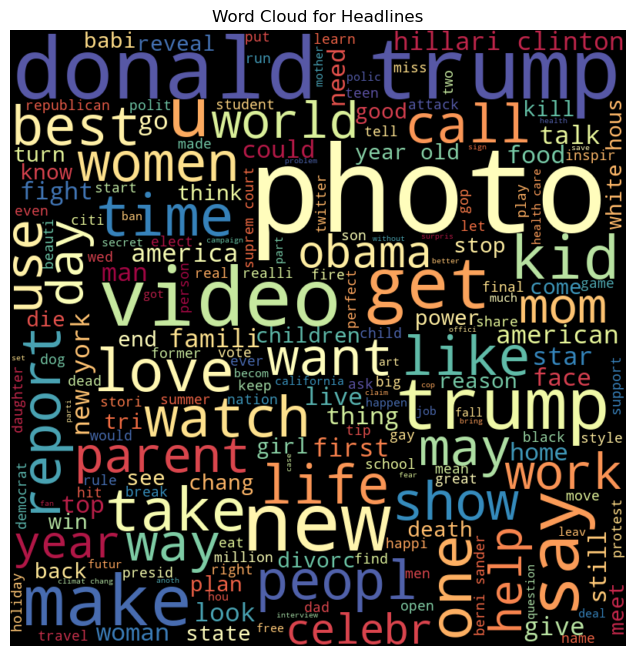

In [41]:
# Plot a word cloud for the Headlines
plot_word_cloud(lemmatized_words, 'Headlines')

In [42]:
# Process the 'short description' column and plot the word cloud
df, lemmatized_words = process_column(df, 'short_description')

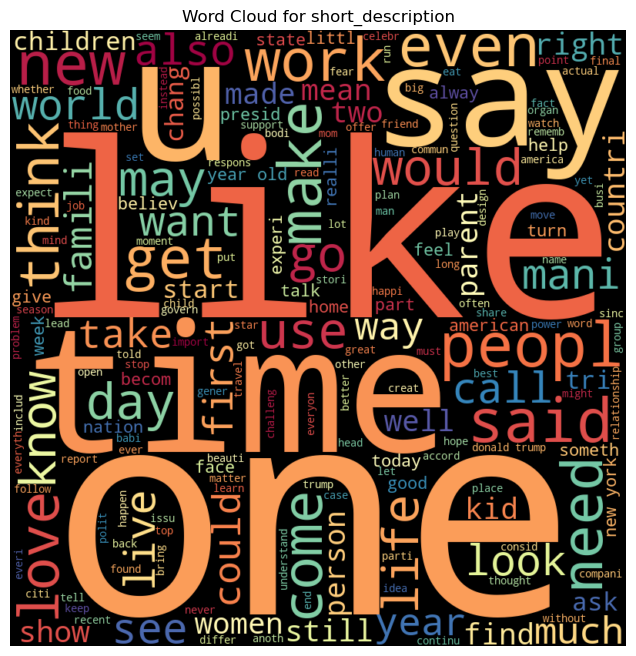

In [43]:
plot_word_cloud(lemmatized_words, 'short_description')

In [44]:
# Process the 'combined info' column and plot the word cloud
df, lemmatized_words = process_column(df, 'combined_info')

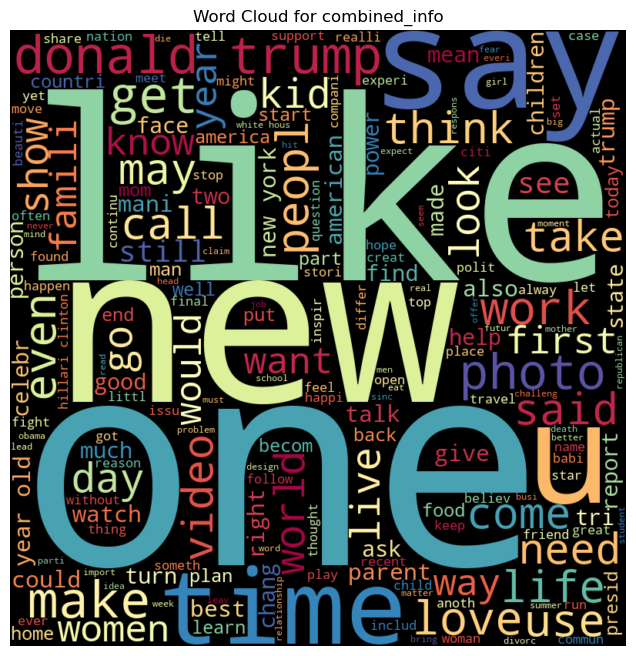

In [45]:
plot_word_cloud(lemmatized_words, 'combined_info')

In [46]:
df['combined_info'][100]

'U.S.: Russia To Buy Rockets, Artillery Shells From North Korea The finding comes after the Biden administration confirmed that the Russian military in August took delivery of Iranian-manufactured drones for use in Ukraine.'

In [47]:
df['processed_combined_info'][100]

'u russia buy rocket artilleri shell north korea find come biden administr confirm russian militari august took deliveri iranian manufactur drone use ukrain'

**Split the data into training and test sets**

In [48]:
df.head()

,link,headline,category,short_description,authors,date,word_count_headline,word_count_description,combined_info,word_count_combined,year,month,processed_headline,processed_short_description,processed_combined_info
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,11,29,Over 4 Million Americans Roll Up Sleeves For O...,40,2022,9,4 million american roll sleev omicron target c...,health expert said earli predict whether deman...,4 million american roll sleev omicron target c...
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,13,28,"American Airlines Flyer Charged, Banned For Li...",41,2022,9,american airlin flyer charg ban life punch fli...,subdu passeng crew fled back aircraft confront...,american airlin flyer charg ban life punch fli...
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,13,12,23 Of The Funniest Tweets About Cats And Dogs ...,25,2022,9,23 funniest tweet cat dog week sept 17 23,dog understand could eaten,23 funniest tweet cat dog week sept 17 23 dog ...
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,9,25,The Funniest Tweets From Parents This Week (Se...,34,2022,9,funniest tweet parent week sept 17 23,accident put grown toothpast toddler toothbrus...,funniest tweet parent week sept 17 23 accident...
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,11,25,Woman Who Called Cops On Black Bird-Watcher Lo...,36,2022,9,woman call cop black bird watcher lose lawsuit...,ami cooper accus invest firm franklin templeto...,woman call cop black bird watcher lose lawsuit...


**Removal of the unique words from "processed_combined_info"**  
Unique words that appear only once in the entire corpus will not be very useful for classification of categories. These words will be removed.

In [49]:
def remove_unique_words(df, column):
    # Extract all the words from all the speeches in the 'Processed_Text' column
    split_words = df[column].str.split().tolist()
    # Flatten the list of lists and count the frequency of each word
    word_frequency = Counter(word for row in split_words for word in row)
    print(f'word count: {len(word_frequency)}')
    # Obtain a set of all the words appearing only once (unique words)
    unique_words = set()
    for word, count in word_frequency.items():
        if count == 1:
            unique_words.add(word)
    print(f'num unique words: {len(unique_words)}')   
    
    # Remove the unique words from all articles of the specified column
    col_without_unique = []
    for row in split_words:
        row_without_unique = []
        # Search through all words in each row and only keep the words that are not in the unique word set
        for word in row:
            if word not in unique_words:
                row_without_unique.append(word)
        # Join the word lists into a string and append to the column series.
        col_without_unique.append(" ".join(row_without_unique))
        
    # Apply the column series to the specified column
    df[column] = col_without_unique
    return df


In [50]:
df = remove_unique_words(df, 'processed_combined_info')

word count: 62896
num unique words: 25711


There are 62,896 different words in the entire corpus. 25,711 words appear only once. They were removed from the corpus.

**Split the data into training and test sets**

In [51]:
# 1. Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(df["processed_combined_info"],df["category"],test_size=0.2,
                                    stratify=df["category"], random_state=12, shuffle=True)

### Text Vectorization

Machine learning models require numerical input rather than textual, so text needs to be converted into vectors. Converting text into numerical data is called 'vectorization' or 'embedding'.<br>

**Bag of words** is a basic method that converts text to vectors. Each word in the corpus is given an index and the word's frequency is associated with it. There are no more complex structures for this method.<br>

It was observed that bag of words did not perform as well as tf-idf for the baseline. It will be evaluated again on the more complex models.

**Term Frequency-Inverse Document Frequencies (Tf-Idf)**  
is a more advanced method. Instead of just counting the number of words, tf-Idf  also adjusts word values based on their occurrence frequency in all the headline rows, reducing the weight to the more commonly occurring terms.

In [52]:
# 2. Vectorization - Method 1 - This limits the number of features to the top max_features most frequent terms
vectorizer = TfidfVectorizer(max_features=50000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [53]:
# The model was the highest accuracy deployed the previous method of Tf-idf vectorization
"""
# 2. Vectorization - Method 2
# Exclude the words that appear in more than 95% of the combined_info entries and
# Include only words that appear in 2 or more documents.

# Set up the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)
"""

"\n# 2. Vectorization - Method 2\n# Exclude the words that appear in more than 95% of the combined_info entries and\n# Include only words that appear in 2 or more documents.\n\n# Set up the TfidfVectorizer\ntfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')\n\n# Fit and transform the training data\nX_train_vec = tfidf_vectorizer.fit_transform(X_train)\n\n# Transform the test data\nX_test_vec = tfidf_vectorizer.transform(X_test)\n"

This method was observed to work best for all the text vectorization methods tested, unless a high value of max_features was used in Method 1.

**Word2vec**  
This is a more advanced neural network-based algorithm that learns word associations from a large corpus of text. Word2vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors. Credit: Analytics Vidhya.


It was observed that Word2vec did not perform as well as tf-idf for the baseline models. It will be evaluated again on the more complex models.

## Machine Learning  

Two models have been used as a baseline for testing the dataset. A Multinomial Naive-Bayes model and a Logistic Regression model. These are two basic models. The purpose of this section for the mid-semester report is to demonstrate that a baseline model can be used to produce an output on the chosen dataset. The models have been left with their default hyperparameter settings and were not tuned. For the final report, more advanced models will be evaluated and tuned to obtain maximum performance. 

In the baseline, various text processing and vectorization steps were configured to determine which steps work best for this dataset. Please refer to the midsemester report for the evaluation of the preprocessing steps. The configuration shown here is for the best combination of all the preprocessing steps that were evaluated.

Note that the best result was achieved on the logistic regression model.

**Multinomial Naive-Bayes Model**

In [54]:
# 3. Train the Naive-Bayes model
nb1 = MultinomialNB()
nb1.fit(X_train_vec, y_train)

MultinomialNB()

In [55]:
# 4. Evaluate the model
y_pred_nb1 = nb1.predict(X_test_vec)

In [56]:
# Display the model's classification accuracy
accuracy_nb1 = accuracy_score(y_test, y_pred_nb1)
print(f"Accuracy: {accuracy_nb1 * 100:.2f}%")

# Classification Report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb1, labels=sorted_labels))

Accuracy: 43.64%

Classification Report:



C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       302
ARTS & CULTURE       0.00      0.00      0.00       268
  BLACK VOICES       0.44      0.00      0.01       917
      BUSINESS       0.62      0.06      0.11      1198
       COLLEGE       0.00      0.00      0.00       228
        COMEDY       0.82      0.03      0.06      1077
         CRIME       0.74      0.06      0.12       712
CULTURE & ARTS       0.50      0.00      0.01       215
       DIVORCE       0.97      0.10      0.18       685
     EDUCATION       0.00      0.00      0.00       203
 ENTERTAINMENT       0.45      0.79      0.57      3472
   ENVIRONMENT       0.00      0.00      0.00       289
         FIFTY       0.00      0.00      0.00       279
  FOOD & DRINK       0.67      0.56      0.61      1268
     GOOD NEWS       0.00      0.00      0.00       279
         GREEN       1.00      0.01      0.02       524
HEALTHY LIVING       0.87      0.01      0.02  

C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For the Naive-Bayes model, the minority classes were often never predicted. Class imbalance is clearly an issue with this model.

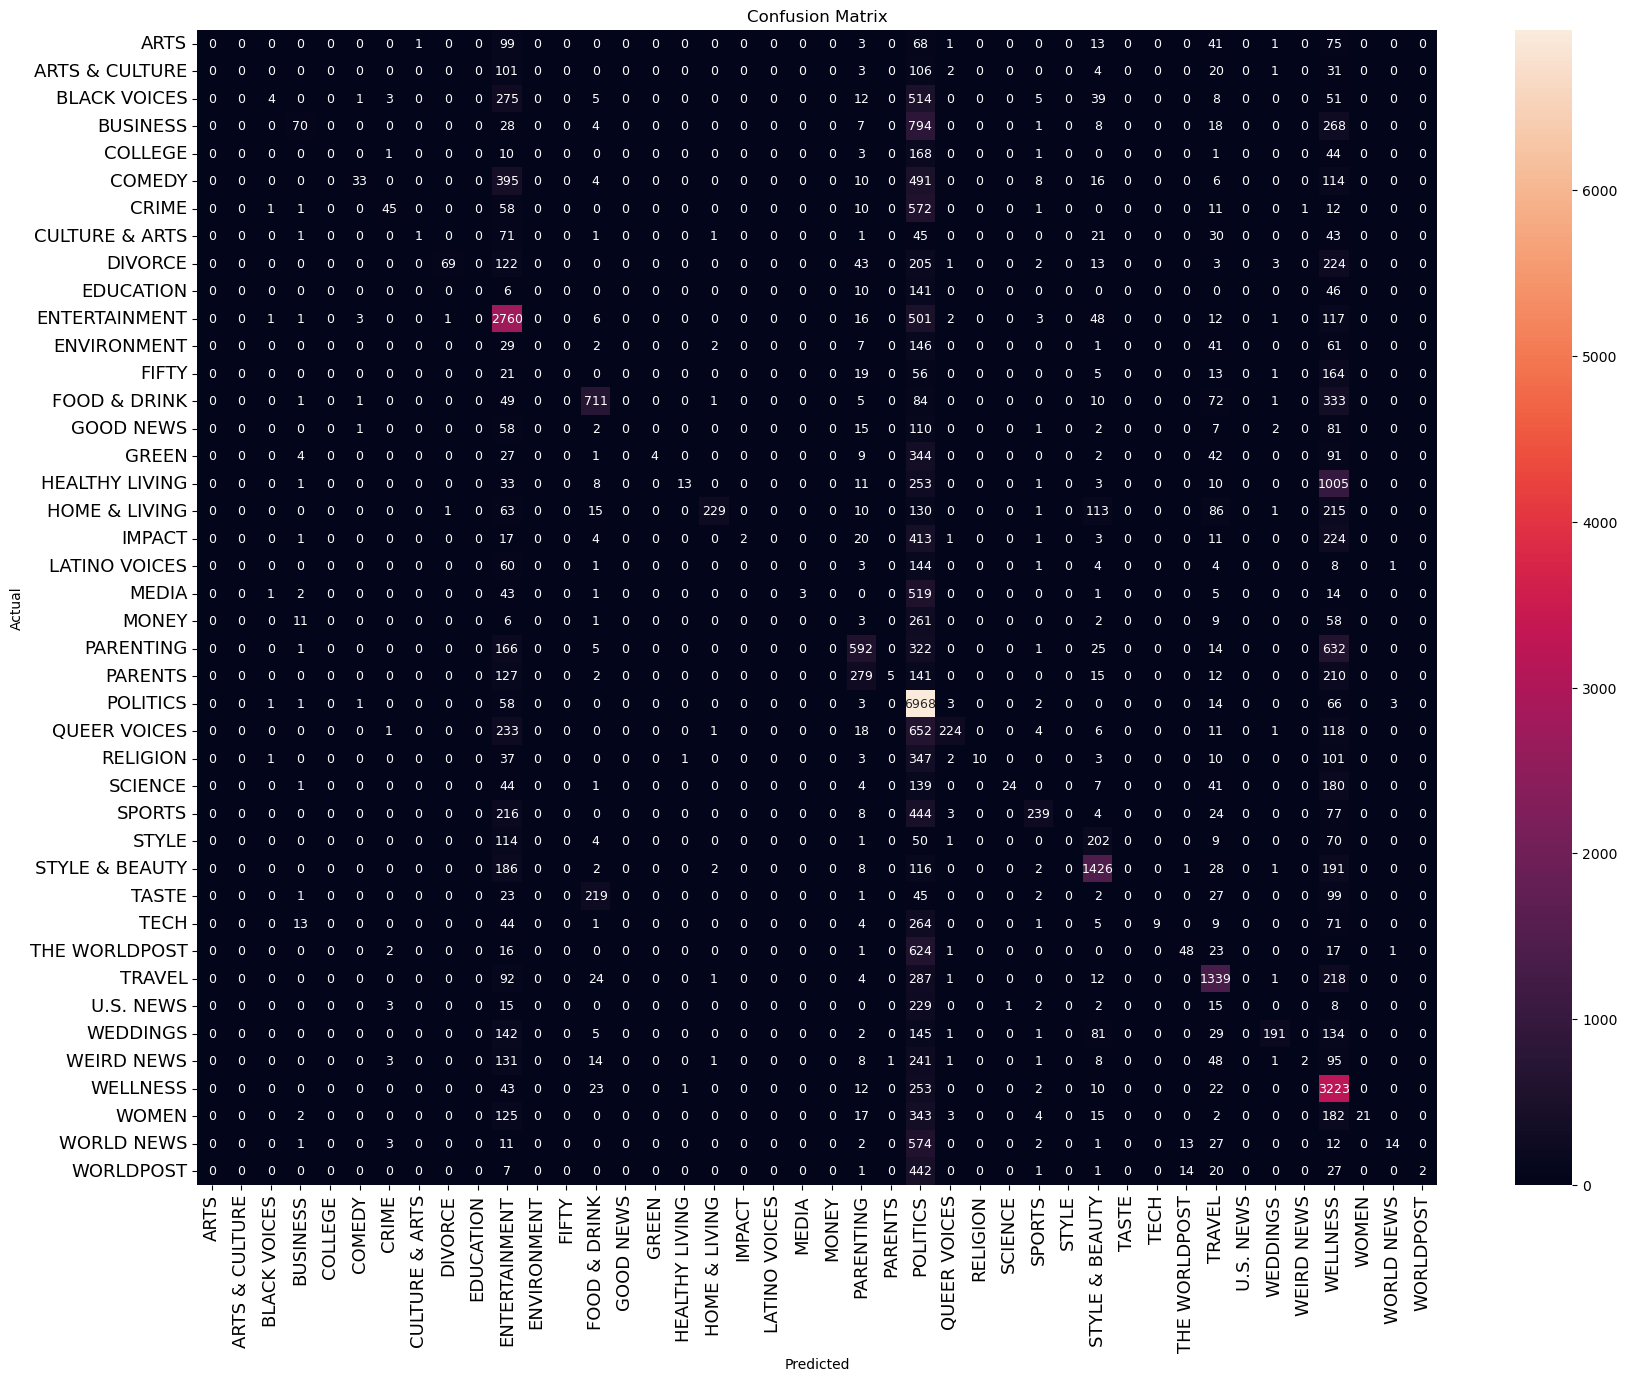

In [57]:
# Generate the confusion matrix
conf_matrix_nb1 = confusion_matrix(y_test, y_pred_nb1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix_nb1, annot=True, fmt="d", annot_kws={"size": 9},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)  
plt.yticks(fontsize=13)  
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Logistic Regression Model**

In [58]:
# 3. Train the Logistic Regression model
lr1 = LogisticRegression(max_iter=600, random_state=12)
lr1.fit(X_train_vec, y_train)

LogisticRegression(max_iter=600, random_state=12)

In [59]:
# 4. Evaluate the model
y_pred_lr1 = lr1.predict(X_test_vec)

In [60]:
# Verify the predictions and test set label counts.
from collections import Counter

label_counts = Counter(y_pred_lr1)
print(label_counts)

Counter({'POLITICS': 9189, 'WELLNESS': 5413, 'ENTERTAINMENT': 4891, 'TRAVEL': 2380, 'STYLE & BEAUTY': 2243, 'PARENTING': 2171, 'FOOD & DRINK': 1524, 'BUSINESS': 1120, 'QUEER VOICES': 1056, 'SPORTS': 996, 'HOME & LIVING': 832, 'COMEDY': 754, 'WEDDINGS': 719, 'CRIME': 694, 'HEALTHY LIVING': 666, 'BLACK VOICES': 591, 'DIVORCE': 587, 'THE WORLDPOST': 552, 'WOMEN': 492, 'GREEN': 459, 'IMPACT': 429, 'WORLD NEWS': 397, 'MEDIA': 383, 'RELIGION': 373, 'PARENTS': 358, 'WEIRD NEWS': 334, 'SCIENCE': 304, 'TECH': 280, 'WORLDPOST': 265, 'MONEY': 235, 'ARTS': 168, 'COLLEGE': 156, 'STYLE': 145, 'EDUCATION': 126, 'ENVIRONMENT': 101, 'ARTS & CULTURE': 96, 'TASTE': 86, 'GOOD NEWS': 81, 'FIFTY': 77, 'CULTURE & ARTS': 73, 'LATINO VOICES': 64, 'U.S. NEWS': 35})


In [61]:
label_counts2 = Counter(y_test)
print(label_counts2)

Counter({'POLITICS': 7120, 'WELLNESS': 3589, 'ENTERTAINMENT': 3472, 'TRAVEL': 1979, 'STYLE & BEAUTY': 1963, 'PARENTING': 1758, 'HEALTHY LIVING': 1338, 'QUEER VOICES': 1269, 'FOOD & DRINK': 1268, 'BUSINESS': 1198, 'COMEDY': 1077, 'SPORTS': 1015, 'BLACK VOICES': 917, 'HOME & LIVING': 864, 'PARENTS': 791, 'THE WORLDPOST': 733, 'WEDDINGS': 731, 'WOMEN': 714, 'CRIME': 712, 'IMPACT': 697, 'DIVORCE': 685, 'WORLD NEWS': 660, 'MEDIA': 589, 'WEIRD NEWS': 555, 'GREEN': 524, 'WORLDPOST': 515, 'RELIGION': 515, 'STYLE': 451, 'SCIENCE': 441, 'TECH': 421, 'TASTE': 419, 'MONEY': 351, 'ARTS': 302, 'ENVIRONMENT': 289, 'GOOD NEWS': 279, 'FIFTY': 279, 'U.S. NEWS': 275, 'ARTS & CULTURE': 268, 'COLLEGE': 228, 'LATINO VOICES': 226, 'CULTURE & ARTS': 215, 'EDUCATION': 203})


In [62]:
# Display the model's classififcation accuracy
accuracy = accuracy_score(y_test, y_pred_lr1)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Displaying the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr1, labels=sorted_labels))

Accuracy: 60.51%

Classification Report:

                precision    recall  f1-score   support

          ARTS       0.43      0.24      0.31       302
ARTS & CULTURE       0.46      0.16      0.24       268
  BLACK VOICES       0.52      0.34      0.41       917
      BUSINESS       0.51      0.48      0.49      1198
       COLLEGE       0.51      0.35      0.41       228
        COMEDY       0.58      0.41      0.48      1077
         CRIME       0.57      0.56      0.57       712
CULTURE & ARTS       0.67      0.23      0.34       215
       DIVORCE       0.80      0.69      0.74       685
     EDUCATION       0.43      0.27      0.33       203
 ENTERTAINMENT       0.55      0.78      0.65      3472
   ENVIRONMENT       0.57      0.20      0.30       289
         FIFTY       0.49      0.14      0.21       279
  FOOD & DRINK       0.62      0.75      0.68      1268
     GOOD NEWS       0.48      0.14      0.22       279
         GREEN       0.45      0.40      0.42       524
HEALT

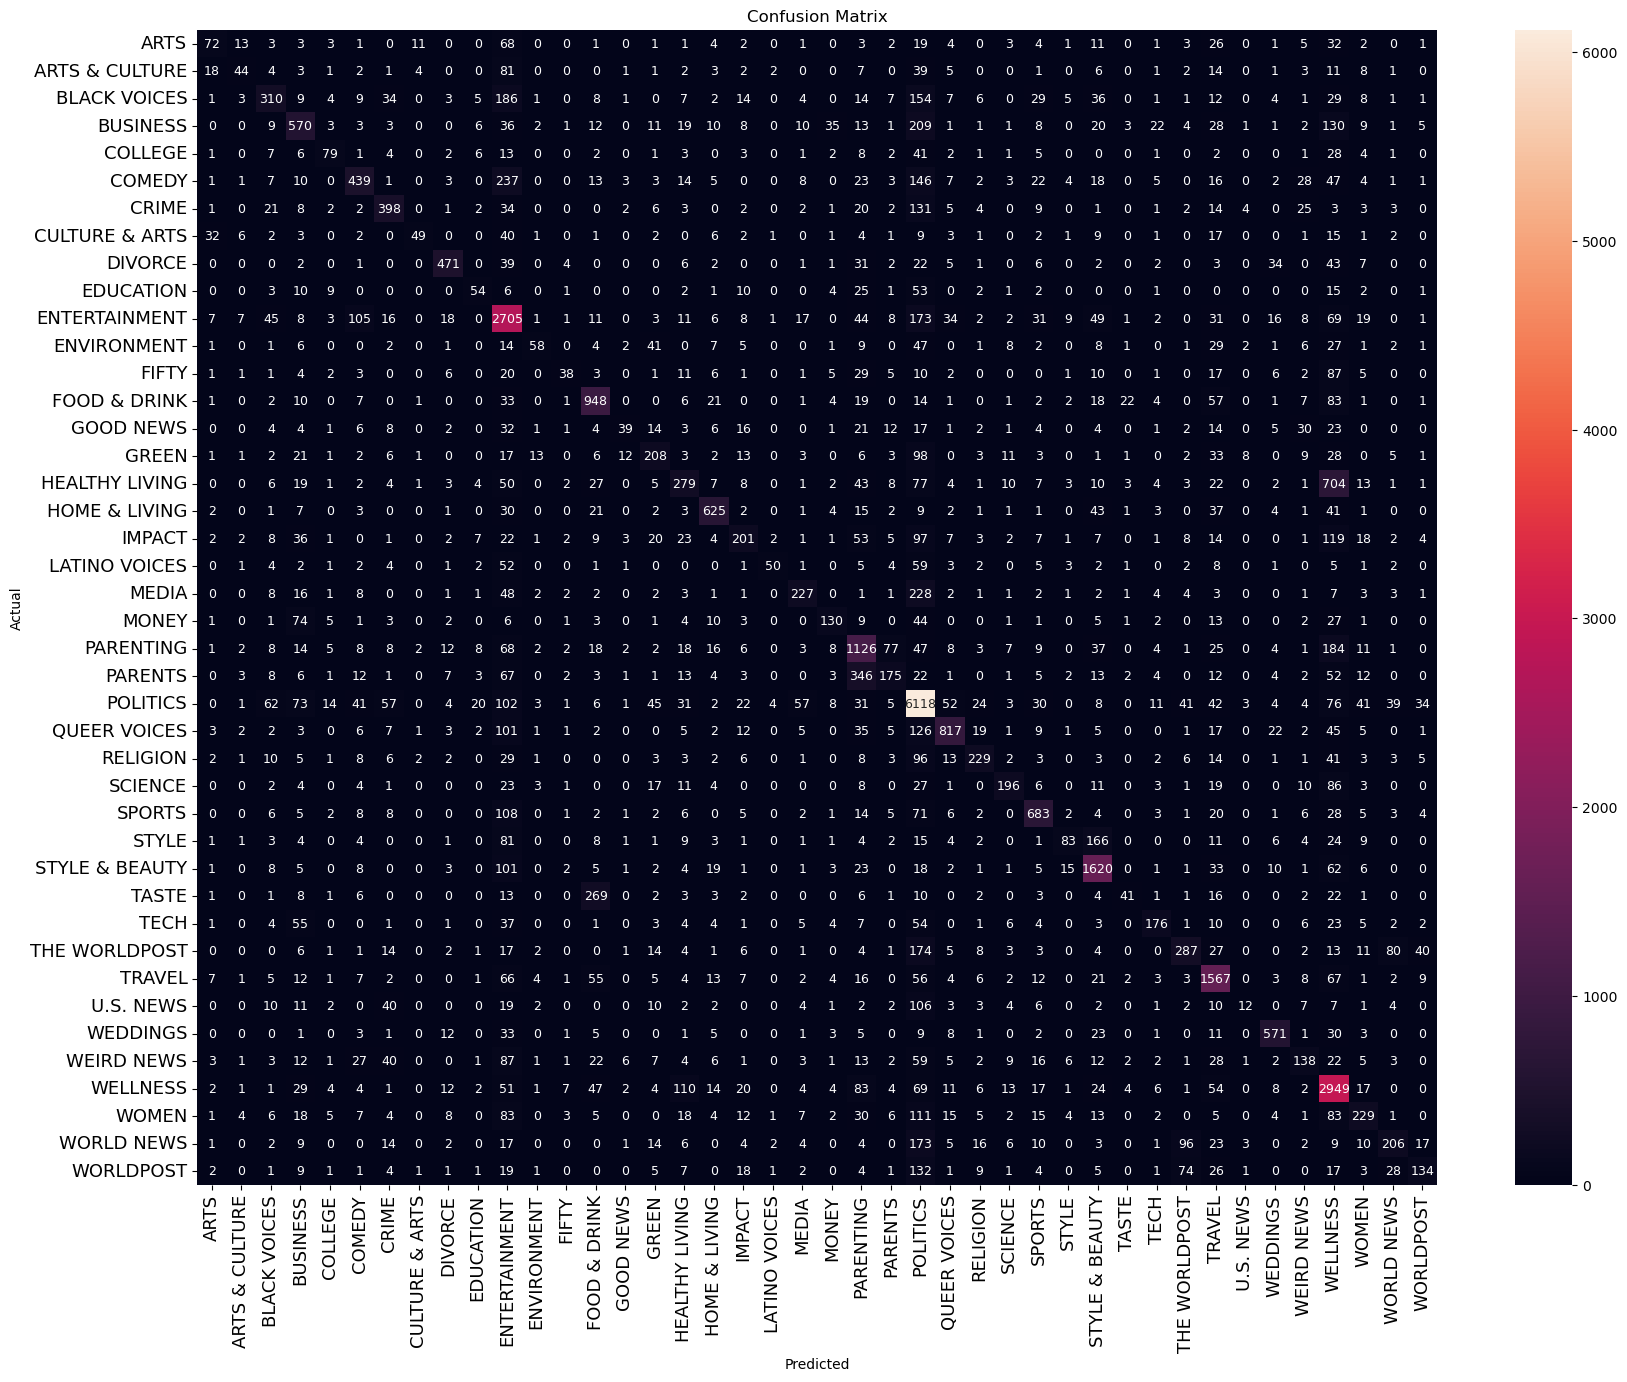

In [63]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 9},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


The best model is the logistic regression model which not only had a much higher accuracy than the Naive-Bayes, but it also made predictions for every label. Further work will continue on this project with more advanced classifiers.